## Import Libraries and Raw Data

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from itertools import chain
from os import makedirs

df = pd.read_csv("study_data.csv")

In [3]:
df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,t3_tlx_3,t3_tlx_4,t3_tlx_5,post_0_1,post_0_0,post_1_1,post_1_0,post_2,post_3,post_4
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,How hard did you have to work to accomplish yo...,"How insecure, discouraged, irritated, stressed...",How useful was the provenance summary in answe...,"Overall, which provenance format was most help...",Please explain your choice.,"Overall, which provenance format was most enjo...",Please explain your choice,Assuming a tool that is ready and available to...,Assuming a tool that is ready and available to...,Is there any comments you would like to add be...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID124""}","{""ImportId"":""QID125""}","{""ImportId"":""QID126""}","{""ImportId"":""QID69_1""}","{""ImportId"":""QID159_TEXT""}","{""ImportId"":""QID128_1""}","{""ImportId"":""QID160_TEXT""}","{""ImportId"":""QID66_TEXT""}","{""ImportId"":""QID67_TEXT""}","{""ImportId"":""QID71_TEXT""}"
2,2023-11-19 15:37:38,2023-11-19 16:20:36,IP Address,128.189.31.173,100,2576,True,2023-11-19 16:20:36,R_2PClVj6LY26Lbkb,NaN,...,4,2,2,5,The graph was confusing and overwhelming. The ...,5,I felt there was a more logical flow of inform...,Integrating code executions into text summarie...,If it was confusing and not very helpful or if...,That was fun. Thanks.
3,2023-11-19 16:24:13,2023-11-19 17:07:50,IP Address,128.189.31.173,100,2617,True,2023-11-19 17:07:51,R_3PtxsBtXhKCaoq8,NaN,...,3,2,2,4,The text was slightly more useful for answerin...,3,The graph was visually easier to interpret for...,I would like to use this tool during the devel...,If there was a lack of documentation for the t...,No.
4,2023-11-20 16:19:11,2023-11-20 16:50:23,IP Address,128.189.30.10,100,1871,True,2023-11-20 16:50:23,R_2qw33WYHS47omRA,NaN,...,3,3,2,4,I felt that the text one was a higher level su...,2,The graph provided more indepth analysis if yo...,Highlighting of linked routes (when you hover ...,No.,NaN


## Process Raw Data

In [4]:
# Preprocess
%run process.py study_data.csv study_data_processed.csv

In [122]:
df = pd.read_csv("study_data_processed.csv")
makedirs("fig", exist_ok=True)

## Study Demographics

In [135]:
# Grab the columns that collect information on occupation and which fields they work in
demographic_df = df.loc[:,["pre_1", "pre_1_7_TEXT", "pre_2", "pre_2_7_TEXT"]]

# Respondents are allowed to input their own fields and choose mutliple
# So here we split them into lists 
demographic_df['field_val'] = demographic_df['pre_2'].str.split(',')
demographic_df['field_text'] = demographic_df['pre_2_7_TEXT'].str.split(',')

# Then we remove any instance of "Other" as we'll later concat the user-supplied and default fields into one list
# This also requires we replace any NaNs with an empty list
demographic_df.field_val = demographic_df.field_val.apply(lambda field_list: [field for field in field_list if field != "Other"])
demographic_df["field_text"].loc[demographic_df["field_text"].isnull()] = demographic_df["field_text"].loc[demographic_df["field_text"].isnull()].apply(lambda x: [])

# Then we'll repeat for occuption, although this is mostly for symmetry as they should all only have one response
demographic_df['occupation_val'] = demographic_df['pre_1'].str.split(',')
demographic_df['occupation_text'] = demographic_df['pre_1_7_TEXT'].str.split(',')

demographic_df.occupation_val = demographic_df.occupation_val.apply(lambda occupation_list: [occupation for occupation in occupation_list if occupation != "Other (Please specify)"])
demographic_df["occupation_text"].loc[demographic_df["occupation_text"].isnull()] = demographic_df["occupation_text"].loc[demographic_df["occupation_text"].isnull()].apply(lambda x: [])

# Then we add these disjoint columns together and subset out our final occupations and fields columns
demographic_df["fields"] = demographic_df["field_val"] + demographic_df["field_text"]
demographic_df["occupations"] = demographic_df["occupation_val"] + demographic_df["occupation_text"]
demographic_df = demographic_df.loc[:,["occupations","fields"]]

# Turns out it's not necessary because each respondent only had one occupation each
# But it's nice to get rid of the list type
demographic_df = demographic_df.explode("occupations")

# Create an adjacency Matr
lst = sorted(set(chain.from_iterable(demographic_df['fields'])))
s = pd.Series(lst, index=lst)
demographic_adj_matrix = demographic_df.join(demographic_df.pop('fields').apply(lambda x: s.isin(x)).astype(int))
demographic_adj_matrix = demographic_adj_matrix.loc[:, ["occupations", "Data Science", " Computer Science", "Forestry", "Physics", "Bioinformatics", "Visualization", "Information Technology", "Human Robot Interaction ", "Environmental Science"]]
demographic_adj_matrix.index +=1
demographic_adj_matrix

,occupations,Data Science,Computer Science,Forestry,Physics,Bioinformatics,Visualization,Information Technology,Human Robot Interaction,Environmental Science
1,Lecturer,0,0,1,0,0,0,0,0,0
2,Data Scientist,0,0,1,0,0,0,0,0,0
3,Student (Graduate),1,0,0,0,0,1,0,0,0
4,Data Scientist,1,0,0,0,1,0,0,0,1
5,Student (Graduate),0,0,0,0,0,0,0,0,1
6,Research Scientist,0,0,0,0,0,0,0,1,0
7,Professor,1,1,0,1,0,0,0,0,0
8,Database Administrator,0,0,0,0,0,0,1,0,0
9,Student (Graduate),1,0,1,0,0,0,0,0,1
10,Student (Graduate),1,0,0,0,0,0,0,0,0


## Timing

In [12]:
# Timing data
timing_t0_df = df.filter(['t0_prov_type', 't0_timing_Page Submit'])
timing_t1_df = df.filter(['t1_prov_type', 't1_timing_Page Submit'])
timing_t2_df = df.filter(['t2_prov_type', 't2_timing_Page Submit'])
timing_t3_df = df.filter(['t3_prov_type', 't3_timing_Page Submit'])

# Map 'prov_type' values to colors
color_mapping = {'text': 'blue', 'graph': 'orange'}
timing_t0_df['bar_color'] = timing_t0_df['t0_prov_type'].map(color_mapping)
timing_t1_df['bar_color'] = timing_t1_df['t1_prov_type'].map(color_mapping)
timing_t2_df['bar_color'] = timing_t2_df['t2_prov_type'].map(color_mapping)
timing_t3_df['bar_color'] = timing_t3_df['t3_prov_type'].map(color_mapping)

In [13]:
def get_average_timing(timing_df, task_num, type):
    if (type == 'all'):
        return pd.to_numeric(timing_df[f't{task_num}_timing_Page Submit']).mean()
    if (type == 'graph'):
        return pd.to_numeric(timing_df.loc[df[f't{task_num}_prov_type'] == 'graph', f't{task_num}_timing_Page Submit']).mean()
    if (type == 'text'):
        return pd.to_numeric(timing_df.loc[df[f't{task_num}_prov_type'] == 'text', f't{task_num}_timing_Page Submit']).mean()
    
def get_std_timing(timing_df, task_num, type):
    if (type == 'all'):
        return pd.to_numeric(timing_df[f't{task_num}_timing_Page Submit']).std()
    if (type == 'graph'):
        return pd.to_numeric(timing_df.loc[df[f't{task_num}_prov_type'] == 'graph', f't{task_num}_timing_Page Submit']).std()
    if (type == 'text'):
        return pd.to_numeric(timing_df.loc[df[f't{task_num}_prov_type'] == 'text', f't{task_num}_timing_Page Submit']).std()

def print_averages_timing(average, std, graph_average, graph_std, text_average, text_std):
    print("Average: " + str(taverage) + ", Standard Deviation: " + str(std))
    print("T0 Graph Average: " + str(graph_average) + ", Standard Deviation: " + str(graph_std))
    print("T0 Text Average: " + str(ttext_average) + ", Standard Deviation: " + str(text_std))

In [14]:
t0_avg_timing = get_average_timing(df, 0, 'all')
t0_timing_avg_graph = get_average_timing(df, 0, 'graph')
t0_timing_avg_text = get_average_timing(df, 0, 'text')

t0_std_timing = get_std_timing(df, 0, 'all')
t0_timing_std_graph = get_std_timing(df, 0, 'graph')
t0_timing_std_text = get_std_timing(df, 0, 'text')

t1_avg_timing = get_average_timing(df, 1, 'all')
t1_timing_avg_graph = get_average_timing(df, 1, 'graph')
t1_timing_avg_text = get_average_timing(df, 1, 'text')

t1_timing_std = get_std_timing(df, 1, 'all')
t1_timing_std_graph = get_std_timing(df, 1, 'graph')
t1_timing_std_text = get_std_timing(df, 1, 'text')

t2_avg_timing = get_average_timing(df, 2, 'all')
t2_timing_avg_graph = get_average_timing(df, 2, 'graph')
t2_timing_avg_text = get_average_timing(df, 2, 'text')

t2_timing_std = get_std_timing(df, 2, 'all')
t2_timing_std_graph = get_std_timing(df, 2, 'graph')
t2_timing_std_text = get_std_timing(df, 2, 'text')

t3_avg_timing = get_average_timing(df, 3, 'all')
t3_timing_avg_graph = get_average_timing(df, 3, 'graph')
t3_timing_avg_text = get_average_timing(df, 3, 'text')

t3_timing_std = get_std_timing(df, 3, 'all')
t3_timing_std_graph = get_std_timing(df, 3, 'graph')
t3_timing_std_text = get_std_timing(df, 3, 'text')

timing_text_data = {'task': ['Task 1', 'Task 2', 'Task 3', 'Task 4'], 
                'timing_score_avg_text': [t0_timing_avg_text, t1_timing_avg_text, t2_timing_avg_text, t3_timing_avg_text],
                'timing_score_avg_graph': [t0_timing_avg_graph, t1_timing_avg_graph, t2_timing_avg_graph, t3_timing_avg_graph],
                'timing_score_std_text': [t0_timing_std_text, t1_timing_std_text, t2_timing_std_text, t3_timing_std_text],
                'timing_score_std_graph': [t0_timing_std_graph, t1_timing_std_graph, t2_timing_std_graph, t3_timing_std_graph]}

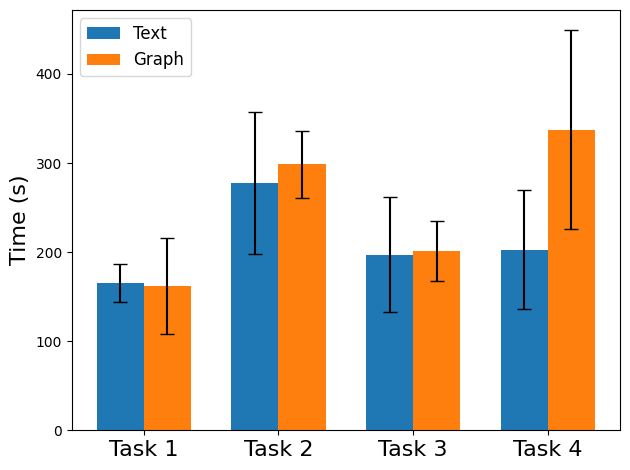

In [20]:
# Create a DataFrame
timing_df = pd.DataFrame(timing_text_data)

# Plot side-by-side bar graph
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(timing_df['task']))

# Bar for text
text_bar = ax.bar([idx - bar_width/2 for idx in index], timing_df['timing_score_avg_text'], bar_width, label='Text', yerr=timing_df['timing_score_std_text'], capsize=5)

# Bar for graph
graph_bar = ax.bar([idx + bar_width/2 for idx in index], timing_df['timing_score_avg_graph'], bar_width, label='Graph', yerr=timing_df['timing_score_std_graph'], capsize=5)

# Add labels and title
ax.set_ylabel('Time (s)', fontsize=16)
#ax.set_title('Average Time to Complete Tasks', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(timing_df['task'], fontsize=16)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('fig/timing_scores.png', format='png')
plt.show()

## Correctness

In [21]:
def get_average_score(df, task_num, type):
    if (type == 'all'):
        return pd.to_numeric(df[f't{task_num}_score']).mean()
    if (type == 'graph'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'graph', f't{task_num}_score']).mean()
    if (type == 'text'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'text', f't{task_num}_score']).mean()
    
def get_std_score(df, task_num, type):
    if (type == 'all'):
        return pd.to_numeric(df[f't{task_num}_score']).std()
    if (type == 'graph'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'graph', f't{task_num}_score']).std()
    if (type == 'text'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'text', f't{task_num}_score']).std()

def print_averages_score(average, std, graph_average, graph_std, text_average, text_std):
    print("Average: " + str(taverage) + ", Standard Deviation: " + str(std))
    print("T0 Graph Average: " + str(graph_average) + ", Standard Deviation: " + str(graph_std))
    print("T0 Text Average: " + str(text_average) + ", Standard Deviation: " + str(text_std))

In [22]:
t0_avg_score = get_average_score(df, 0, 'all')
t0_score_avg_graph = get_average_score(df, 0, 'graph')
t0_score_avg_text = get_average_score(df, 0, 'text')

t0_std_score = get_std_score(df, 0, 'all')
t0_score_std_graph = get_std_score(df, 0, 'graph')
t0_score_std_text = get_std_score(df, 0, 'text')

t1_avg_score = get_average_score(df, 1, 'all')
t1_score_avg_graph = get_average_score(df, 1, 'graph')
t1_score_avg_text = get_average_score(df, 1, 'text')

t1_score_std = get_std_score(df, 1, 'all')
t1_score_std_graph = get_std_score(df, 1, 'graph')
t1_score_std_text = get_std_score(df, 1, 'text')

t2_avg_score = get_average_score(df, 2, 'all')
t2_score_avg_graph = get_average_score(df, 2, 'graph')
t2_score_avg_text = get_average_score(df, 2, 'text')

t2_score_std = get_std_score(df, 2, 'all')
t2_score_std_graph = get_std_score(df, 2, 'graph')
t2_score_std_text = get_std_score(df, 2, 'text')

t3_avg_score = get_average_score(df, 3, 'all')
t3_score_avg_graph = get_average_score(df, 3, 'graph')
t3_score_avg_text = get_average_score(df, 3, 'text')

t3_score_std = get_std_score(df, 3, 'all')
t3_score_std_graph = get_std_score(df, 3, 'graph')
t3_score_std_text = get_std_score(df, 3, 'text')

score_text_data = {'task': ['Task 0', 'Task 1', 'Task 2', 'Task 3'], 
                'score_avg_text': [t0_score_avg_text, t1_score_avg_text, t2_score_avg_text, t3_score_avg_text],
                'score_avg_graph': [t0_score_avg_graph, t1_score_avg_graph, t2_score_avg_graph, t3_score_avg_graph],
                'score_std_text': [t0_score_std_text, t1_score_std_text, t2_score_std_text, t3_score_std_text],
                'score_std_graph': [t0_score_std_graph, t1_score_std_graph, t2_score_std_graph, t3_score_std_graph]}

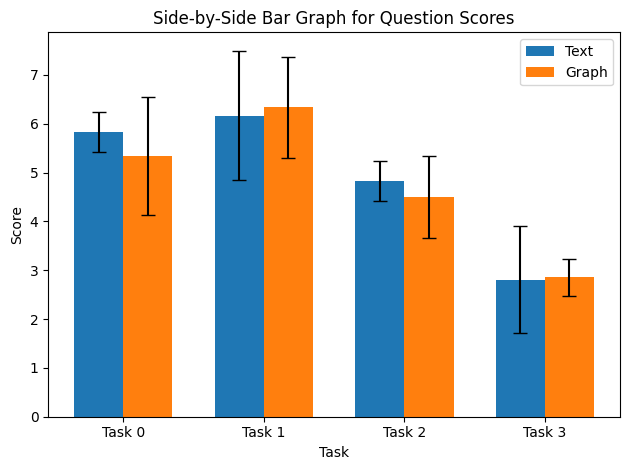

In [23]:
# Create a DataFrame
score_df = pd.DataFrame(score_text_data)

# Plot side-by-side bar graph
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(score_df['task']))

# Bar for text
text_bar = ax.bar([idx - bar_width/2 for idx in index], score_df['score_avg_text'], bar_width, label='Text', yerr=score_df['score_std_text'], capsize=5)

# Bar for graph
graph_bar = ax.bar([idx + bar_width/2 for idx in index], score_df['score_avg_graph'], bar_width, label='Graph', yerr=score_df['score_std_graph'], capsize=5)

# Add labels and title
ax.set_xlabel('Task')
ax.set_ylabel('Score')
ax.set_title('Side-by-Side Bar Graph for Question Scores')
ax.set_xticks(index)
ax.set_xticklabels(score_df['task'])
ax.legend()

plt.tight_layout()

plt.savefig('fig/task_scores.png', format='png')
plt.show()

In [24]:
def get_average_score_percent(df, task_num, type):
    if (type == 'all'):
        return pd.to_numeric(df[f't{task_num}_score_percent']).mean()
    if (type == 'graph'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'graph', f't{task_num}_score_percent']).mean()
    if (type == 'text'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'text', f't{task_num}_score_percent']).mean()
    
def get_std_score_percent(df, task_num, type):
    if (type == 'all'):
        return pd.to_numeric(df[f't{task_num}_score_percent']).std()
    if (type == 'graph'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'graph', f't{task_num}_score_percent']).std()
    if (type == 'text'):
        return pd.to_numeric(df.loc[df[f't{task_num}_prov_type'] == 'text', f't{task_num}_score_percent']).std()

def print_averages_score_percent(average, std, graph_average, graph_std, text_average, text_std):
    print("Average: " + str(taverage) + ", Standard Deviation: " + str(std))
    print("T0 Graph Average: " + str(graph_average) + ", Standard Deviation: " + str(graph_std))
    print("T0 Text Average: " + str(text_average) + ", Standard Deviation: " + str(text_std))

In [25]:
t0_avg_score_percent = get_average_score_percent(df, 0, 'all')
t0_score_percent_avg_graph = get_average_score_percent(df, 0, 'graph')
t0_score_percent_avg_text = get_average_score_percent(df, 0, 'text')

t0_std_score_percent = get_std_score_percent(df, 0, 'all')
t0_score_percent_std_graph = get_std_score_percent(df, 0, 'graph')
t0_score_percent_std_text = get_std_score_percent(df, 0, 'text')

t1_avg_score_percent = get_average_score_percent(df, 1, 'all')
t1_score_percent_avg_graph = get_average_score_percent(df, 1, 'graph')
t1_score_percent_avg_text = get_average_score_percent(df, 1, 'text')

t1_score_percent_std = get_std_score_percent(df, 1, 'all')
t1_score_percent_std_graph = get_std_score_percent(df, 1, 'graph')
t1_score_percent_std_text = get_std_score_percent(df, 1, 'text')

t2_avg_score_percent = get_average_score_percent(df, 2, 'all')
t2_score_percent_avg_graph = get_average_score_percent(df, 2, 'graph')
t2_score_percent_avg_text = get_average_score_percent(df, 2, 'text')

t2_score_percent_std = get_std_score_percent(df, 2, 'all')
t2_score_percent_std_graph = get_std_score_percent(df, 2, 'graph')
t2_score_percent_std_text = get_std_score_percent(df, 2, 'text')

t3_avg_score_percent = get_average_score_percent(df, 3, 'all')
t3_score_percent_avg_graph = get_average_score_percent(df, 3, 'graph')
t3_score_percent_avg_text = get_average_score_percent(df, 3, 'text')

t3_score_percent_std = get_std_score_percent(df, 3, 'all')
t3_score_percent_std_graph = get_std_score_percent(df, 3, 'graph')
t3_score_percent_std_text = get_std_score_percent(df, 3, 'text')

score_percent_text_data = {'task': ['Task 1', 'Task 2', 'Task 3', 'Task 4'], 
                'score_percent_avg_text': [t0_score_percent_avg_text, t1_score_percent_avg_text, t2_score_percent_avg_text, t3_score_percent_avg_text],
                'score_percent_avg_graph': [t0_score_percent_avg_graph, t1_score_percent_avg_graph, t2_score_percent_avg_graph, t3_score_percent_avg_graph],
                'score_percent_std_text': [t0_score_percent_std_text, t1_score_percent_std_text, t2_score_percent_std_text, t3_score_percent_std_text],
                'score_percent_std_graph': [t0_score_percent_std_graph, t1_score_percent_std_graph, t2_score_percent_std_graph, t3_score_percent_std_graph]}

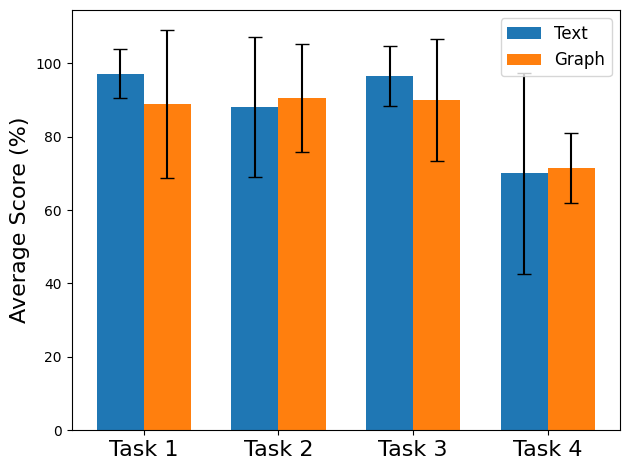

In [26]:
# Create a DataFrame
score_percent_df = pd.DataFrame(score_percent_text_data)

# Plot side-by-side bar graph
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(score_df['task']))

# Bar for text
text_bar = ax.bar([idx - bar_width/2 for idx in index], score_percent_df['score_percent_avg_text'], bar_width, label='Text', yerr=score_percent_df['score_percent_std_text'], capsize=5)

# Bar for graph
graph_bar = ax.bar([idx + bar_width/2 for idx in index], score_percent_df['score_percent_avg_graph'], bar_width, label='Graph', yerr=score_percent_df['score_percent_std_graph'], capsize=5)

# Add labels and title
ax.set_ylabel('Average Score (%)', fontsize=16)
# ax.set_title('Average Question Score Per Task', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(score_percent_text_data['task'], fontsize=16)
ax.legend(fontsize=12)

plt.tight_layout()

plt.savefig('fig/task_scores_percent.png', format='png')
plt.show()

## TLX

In [22]:
def get_average_tlx(df, task_num, type):
    if (type == 'all'):
        return df[f't{task_num}_tlx_score'].mean()
    if (type == 'graph'):
        return df.loc[df['t0_prov_type'] == 'graph', f't{task_num}_tlx_score'].mean()
    if (type == 'text'):
        return df.loc[df['t0_prov_type'] == 'text', f't{task_num}_tlx_score'].mean()
    
def get_std_tlx(timing_df, task_num, type):
    if (type == 'all'):
        return df[f't{task_num}_tlx_score'].std()
    if (type == 'graph'):
        return df.loc[df['t0_prov_type'] == 'graph', f't{task_num}_tlx_score'].std()
    if (type == 'text'):
        return df.loc[df['t0_prov_type'] == 'text', f't{task_num}_tlx_score'].std()

def print_averages_timing(average, std, graph_average, graph_std, text_average, text_std):
    print("T0 Average: " + str(t0_average) + ", Standard Deviation: " + str(t0_std))
    print("T0 Graph Average: " + str(t0_graph_average) + ", Standard Deviation: " + str(t0_graph_std))
    print("T0 Text Average: " + str(t0_text_average) + ", Standard Deviation: " + str(t0_text_std))

In [23]:
t0_tlx_avg = get_average_tlx(df, 0, 'all')
t1_tlx_avg = get_average_tlx(df, 1, 'all')
t2_tlx_avg = get_average_tlx(df, 2, 'all')
t3_tlx_avg = get_average_tlx(df, 3, 'all')

t0_tlx_std = get_std_tlx(df, 0, 'all')
t1_tlx_std = get_std_tlx(df, 1, 'all')
t2_tlx_std = get_std_tlx(df, 2, 'all')
t3_tlx_std = get_std_tlx(df, 3, 'all')

t0_tlx_avg_text = get_average_tlx(df, 0, 'text')
t1_tlx_avg_text = get_average_tlx(df, 1, 'text')
t2_tlx_avg_text = get_average_tlx(df, 2, 'text')
t3_tlx_avg_text = get_average_tlx(df, 3, 'text')

t0_tlx_std_text = get_std_tlx(df, 0, 'text')
t1_tlx_std_text = get_std_tlx(df, 1, 'text')
t2_tlx_std_text = get_std_tlx(df, 2, 'text')
t3_tlx_std_text = get_std_tlx(df, 3, 'text')

t0_tlx_avg_graph = get_average_tlx(df, 0, 'graph')
t1_tlx_avg_graph = get_average_tlx(df, 1, 'graph')
t2_tlx_avg_graph = get_average_tlx(df, 2, 'graph')
t3_tlx_avg_graph = get_average_tlx(df, 3, 'graph')

t0_tlx_std_graph = get_std_tlx(df, 0, 'graph')
t1_tlx_std_graph = get_std_tlx(df, 1, 'graph')
t2_tlx_std_graph = get_std_tlx(df, 2, 'graph')
t3_tlx_std_graph = get_std_tlx(df, 3, 'graph')

tlx_text_data = {'task': ['Task 1', 'Task 2', 'Task 3', 'Task 4'], 
                'tlx_score_avg_text': [t0_tlx_avg_text, t1_tlx_avg_text, t2_tlx_avg_text, t3_tlx_avg_text],
                'tlx_score_avg_graph': [t0_tlx_avg_graph, t1_tlx_avg_graph, t2_tlx_avg_graph, t3_tlx_avg_graph],
                'tlx_score_std_text': [t0_tlx_std_text, t1_tlx_std_text, t2_tlx_std_text, t3_tlx_std_text],
                'tlx_score_std_graph': [t0_tlx_std_graph, t1_tlx_std_graph, t2_tlx_std_graph, t3_tlx_std_graph]}

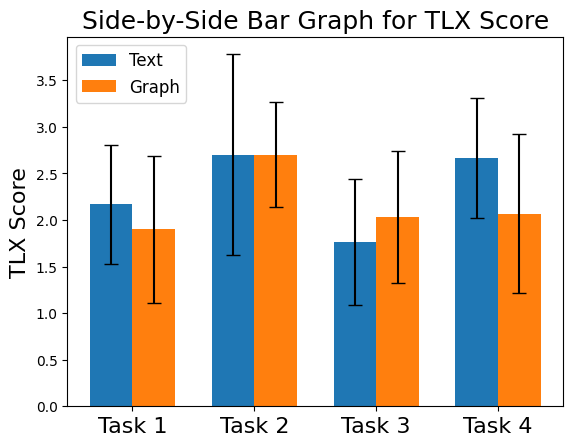

In [24]:
# Create a DataFrame
tlx_df = pd.DataFrame(tlx_text_data)

# Plot side-by-side bar graph
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(tlx_df['task']))

# Bar for text
text_bar = ax.bar([idx - bar_width/2 for idx in index], tlx_df['tlx_score_avg_text'], bar_width, label='Text', yerr=tlx_df['tlx_score_std_text'], capsize=5)

# Bar for graph
graph_bar = ax.bar([idx + bar_width/2 for idx in index], tlx_df['tlx_score_avg_graph'], bar_width, label='Graph', yerr=tlx_df['tlx_score_std_graph'], capsize=5)

# Add labels and title
ax.set_xlabel(None)
ax.set_ylabel('TLX Score', fontsize=16)
ax.set_title('Side-by-Side Bar Graph for TLX Score', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(tlx_df['task'], fontsize=16)
ax.legend(fontsize=12)

plt.savefig('fig/tlx_scores.png', format='png')
plt.show()

In [25]:
def get_average_tlx_norm(df, task_num, type):
    if (type == 'all'):
        return df[f't{task_num}_tlx_avg_normalized'].mean()
    if (type == 'graph'):
        return df.loc[df['t0_prov_type'] == 'graph', f't{task_num}_tlx_avg_normalized'].mean()
    if (type == 'text'):
        return df.loc[df['t0_prov_type'] == 'text', f't{task_num}_tlx_avg_normalized'].mean()
    
def get_std_tlx_norm(timing_df, task_num, type):
    if (type == 'all'):
        return df[f't{task_num}_tlx_avg_normalized'].std()
    if (type == 'graph'):
        return df.loc[df['t0_prov_type'] == 'graph', f't{task_num}_tlx_avg_normalized'].std()
    if (type == 'text'):
        return df.loc[df['t0_prov_type'] == 'text', f't{task_num}_tlx_avg_normalized'].std()

def print_averages_timing_norm(average, std, graph_average, graph_std, text_average, text_std):
    print("T0 Average: " + str(t0_average) + ", Standard Deviation: " + str(t0_std))
    print("T0 Graph Average: " + str(t0_graph_average) + ", Standard Deviation: " + str(t0_graph_std))
    print("T0 Text Average: " + str(t0_text_average) + ", Standard Deviation: " + str(t0_text_std))

In [26]:
t0_tlx_norm_avg = get_average_tlx_norm(df, 0, 'all')
t1_tlx_norm_avg = get_average_tlx_norm(df, 1, 'all')
t2_tlx_norm_avg = get_average_tlx_norm(df, 2, 'all')
t3_tlx_norm_avg = get_average_tlx_norm(df, 3, 'all')

t0_tlx_norm_std = get_std_tlx_norm(df, 0, 'all')
t1_tlx_norm_std = get_std_tlx_norm(df, 1, 'all')
t2_tlx_norm_std = get_std_tlx_norm(df, 2, 'all')
t3_tlx_norm_std = get_std_tlx_norm(df, 3, 'all')

t0_tlx_norm_avg_text = get_average_tlx_norm(df, 0, 'text')
t1_tlx_norm_avg_text = get_average_tlx_norm(df, 1, 'text')
t2_tlx_norm_avg_text = get_average_tlx_norm(df, 2, 'text')
t3_tlx_norm_avg_text = get_average_tlx_norm(df, 3, 'text')

t0_tlx_norm_std_text = get_std_tlx_norm(df, 0, 'text')
t1_tlx_norm_std_text = get_std_tlx_norm(df, 1, 'text')
t2_tlx_norm_std_text = get_std_tlx_norm(df, 2, 'text')
t3_tlx_norm_std_text = get_std_tlx_norm(df, 3, 'text')

t0_tlx_norm_avg_graph = get_average_tlx_norm(df, 0, 'graph')
t1_tlx_norm_avg_graph = get_average_tlx_norm(df, 1, 'graph')
t2_tlx_norm_avg_graph = get_average_tlx_norm(df, 2, 'graph')
t3_tlx_norm_avg_graph = get_average_tlx_norm(df, 3, 'graph')

t0_tlx_norm_std_graph = get_std_tlx_norm(df, 0, 'graph')
t1_tlx_norm_std_graph = get_std_tlx_norm(df, 1, 'graph')
t2_tlx_norm_std_graph = get_std_tlx_norm(df, 2, 'graph')
t3_tlx_norm_std_graph = get_std_tlx_norm(df, 3, 'graph')

tlx_norm_text_data = {'task': ['Task 1', 'Task 2', 'Task 3', 'Task 4'], 
                'tlx_norm_avg_text': [t0_tlx_norm_avg_text, t1_tlx_norm_avg_text, t2_tlx_norm_avg_text, t3_tlx_norm_avg_text],
                'tlx_norm_avg_graph': [t0_tlx_norm_avg_graph, t1_tlx_norm_avg_graph, t2_tlx_norm_avg_graph, t3_tlx_norm_avg_graph],
                'tlx_norm_std_text': [t0_tlx_norm_std_text, t1_tlx_norm_std_text, t2_tlx_norm_std_text, t3_tlx_norm_std_text],
                'tlx_norm_std_graph': [t0_tlx_norm_std_graph, t1_tlx_norm_std_graph, t2_tlx_norm_std_graph, t3_tlx_norm_std_graph]}

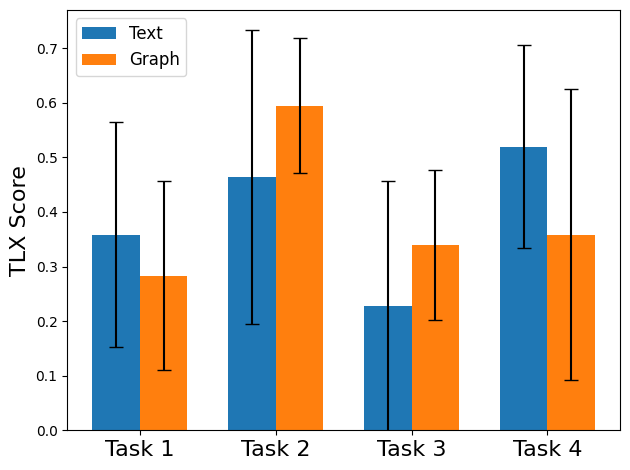

In [27]:
# Create a DataFrame
tlx_norm_df = pd.DataFrame(tlx_norm_text_data)

# Plot side-by-side bar graph
fig1, ax = plt.subplots()

bar_width = 0.35
index = range(len(tlx_norm_df['task']))

# Bar for text
text_bar = ax.bar([idx - bar_width/2 for idx in index], tlx_norm_df['tlx_norm_avg_text'], bar_width, label='Text', yerr=tlx_norm_df['tlx_norm_std_text'], capsize=5)

# Bar for graph
graph_bar = ax.bar([idx + bar_width/2 for idx in index], tlx_norm_df['tlx_norm_avg_graph'], bar_width, label='Graph', yerr=tlx_norm_df['tlx_norm_std_graph'], capsize=5)

# Add labels and title
ax.set_xlabel(None)
ax.set_ylabel('TLX Score', fontsize=16)
ax.set_ylim(bottom=0)
#ax.set_title('Normalized Self-Assigned Cognitive Load Score', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(tlx_norm_df['task'], fontsize=16)
ax.legend(fontsize=12)

plt.tight_layout()

plt.savefig('fig/tlx_norm.png', format='png')
plt.show()

## Post

In [28]:
# Define a mapping dictionary
mapping_dict = {1: 'Graph', 2: 'Mostly Graph', 3: 'Equal', 4: 'Mostly Text', 5: 'Text'}

# Map values in the 'Category' column to new values based on the mapping dictionary
df['post_0_1_mapped'] = df['post_0_1'].map(mapping_dict)
df['post_1_1_mapped'] = df['post_1_1'].map(mapping_dict)

df['post_0_1']
df['post_0_1_mapped']

0             Text
1      Mostly Text
2      Mostly Text
3            Graph
4     Mostly Graph
5      Mostly Text
6      Mostly Text
7            Equal
8     Mostly Graph
9     Mostly Graph
10           Equal
11            Text
Name: post_0_1_mapped, dtype: object

post_0_1_mapped
Text            2
Mostly Text     4
Equal           2
Mostly Graph    3
Graph           1
Name: count, dtype: int64


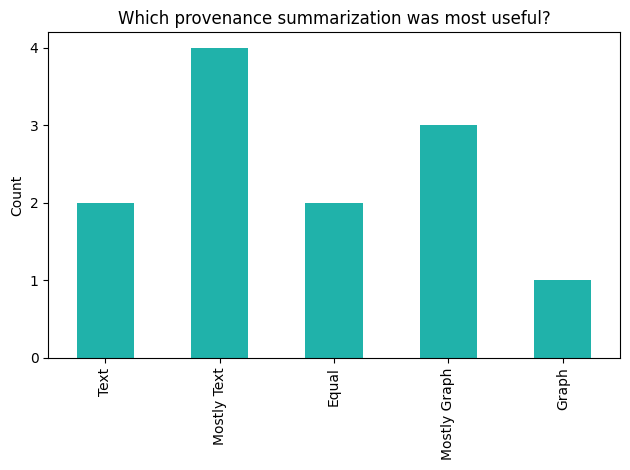

In [29]:
# Summary Preference
# Count the occurrences of each unique text value

x_values = ['Text', 'Mostly Text', 'Equal', 'Mostly Graph', 'Graph']

value_counts = df['post_0_1_mapped'].value_counts().reindex(x_values, fill_value=0)
print(value_counts)

# Plotting a bar graph based on the counts
value_counts.plot(kind='bar', color='lightseagreen')

# Adding labels and title
plt.xlabel(None)
plt.ylabel('Count')
plt.title('Which provenance summarization was most useful?')
plt.yticks(range(int(value_counts.max()) + 1))

plt.tight_layout()

plt.savefig('fig/useful_bar.png', format='png')

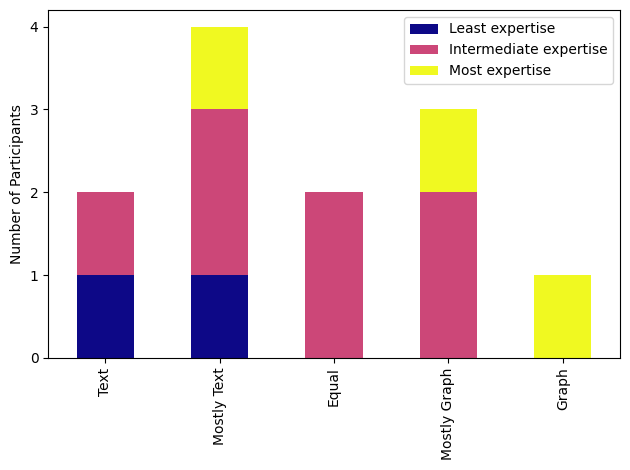

In [30]:
# Group by 'experience' and 'preference', and then unstack to pivot the data
grouped_df = df.groupby(['post_0_1_mapped', 'experience score']).size().unstack(fill_value=0).reindex(x_values, fill_value=0)

# Plot the stacked bar chart
ax = grouped_df.plot(kind='bar', stacked=True, colormap='plasma')

# Set legend labels
legend_labels = {
    0: 'Least expertise',
    1: 'Intermediate expertise',
    2: 'Most expertise'
}

# Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()

# Create a new set of handles and labels with the desired legend labels
new_labels = [legend_labels[int(label)] for label in labels]

# Set the legend with the new handles and labels
plt.legend(handles, new_labels)

# Add labels and title
plt.xlabel(None)
plt.ylabel('Number of Participants')
#plt.title('Which provenance summarization was most useful?')
plt.yticks(range(int(value_counts.max()) + 1))

plt.tight_layout()

plt.savefig('fig/useful_bar_stacked.png', format='png')

post_1_1_mapped
Text            2
Mostly Text     1
Equal           1
Mostly Graph    6
Graph           2
Name: count, dtype: int64


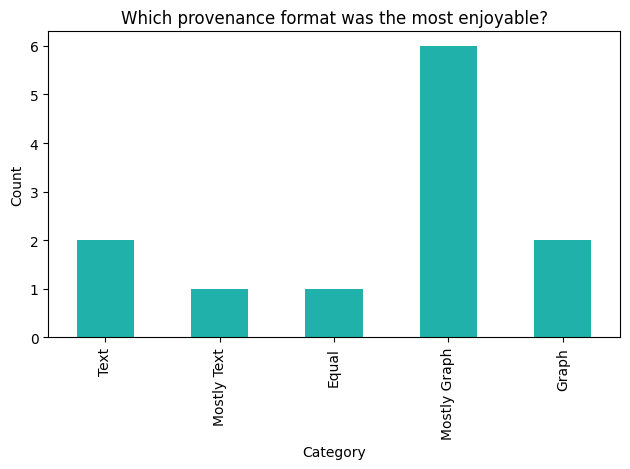

In [31]:
# Summary Preference
x_values = ['Text', 'Mostly Text', 'Equal', 'Mostly Graph', 'Graph']

df_subset = df.iloc[2:]
value_counts = df['post_1_1_mapped'].value_counts().reindex(x_values, fill_value=0)
print(value_counts)

# Plotting a bar graph based on the counts
value_counts.plot(kind='bar', color='lightseagreen')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Which provenance format was the most enjoyable?')
plt.yticks(range(int(value_counts.max()) + 1))

plt.tight_layout()

plt.savefig('fig/enjoy_bar.png', format='png')

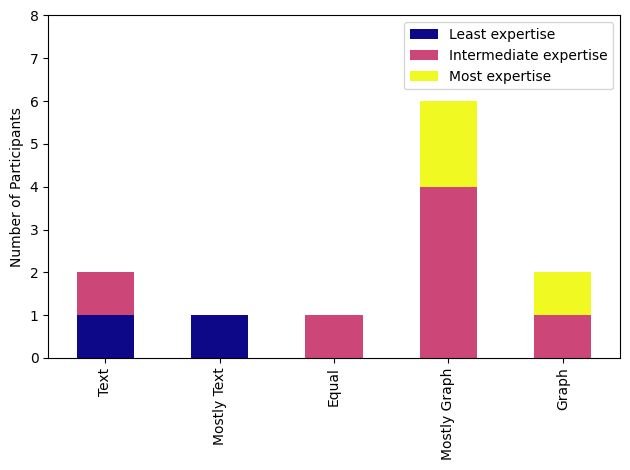

In [32]:
# Group by 'experience' and 'preference', and then unstack to pivot the data
grouped_df = df.groupby(['post_1_1_mapped', 'experience score']).size().unstack(fill_value=0).reindex(x_values, fill_value=0)

# Plot the stacked bar chart
ax = grouped_df.plot(kind='bar', stacked=True, colormap='plasma')

# Set legend labels
legend_labels = {
    0: 'Least expertise',
    1: 'Intermediate expertise',
    2: 'Most expertise'
}

# Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()

# Create a new set of handles and labels with the desired legend labels
new_labels = [legend_labels[int(label)] for label in labels]

# Set the legend with the new handles and labels
plt.legend(handles, new_labels)

# Add labels and title
plt.xlabel(None)
plt.ylabel('Number of Participants')
#plt.title('Which provenance summarization was most enjoyable?')
plt.yticks(range(int(value_counts.max()) + 3))

plt.tight_layout()

plt.savefig('fig/enjoy_bar_stacked.png', format='png')